In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import xarray as xr
import pandas as pd
import pycomlink as pycml

import pycomlink.processing.wet_dry.mlp as mlp

# Load and preprocess example data 

These steps are similar to the steps performed in the notebook "Basic CML processing workflow.ipynb". 

In [4]:
# Load data
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# Do wet-dry classification and determine baseline

This compares 3 different ways of finding wet and dry periods in the CML time series.

**Update**: As tensorflow was removed, so were the methods using neural networks. Hence only one method (the rolling standard deviation method) is shown here.

In [5]:
# wet dry detection using rsd
cmls['wet_rsd'] = cmls.tl.rolling(time=60, center=True).std() > 0.8

# wet dry detection using MLP rain gauge model
cmls['wet_mlp_rg'] = (('cml_id', 'time'), np.zeros([cmls.cml_id.size, cmls.time.size]))
for cml_id in tqdm.tqdm(cmls.cml_id.values):
    mlp_out = mlp.mlp_wet_dry(
        trsl_channel_1 = cmls.sel(cml_id = cml_id).isel(channel_id = 0).tl,
        trsl_channel_2 = cmls.sel(cml_id = cml_id).isel(channel_id = 1).tl,
        model_sel = 'rg' # model based on rain gauge training data
    )
    cmls['wet_mlp_rg'].loc[{'cml_id':cml_id}]=  np.argmax(mlp_out, axis = 1)

# wet dry detection using MLP rain gauge online model
cmls['wet_mlp_rad_online'] = (('cml_id', 'time'), np.zeros([cmls.cml_id.size, cmls.time.size]))
for cml_id in tqdm.tqdm(cmls.cml_id.values):
    mlp_out = mlp.mlp_wet_dry(
        trsl_channel_1 = cmls.sel(cml_id = cml_id).isel(channel_id = 0).tl,
        trsl_channel_2 = cmls.sel(cml_id = cml_id).isel(channel_id = 1).tl,
        model_sel = 'rad_online' # model based on radar training data, online capabilities
    )
    cmls['wet_mlp_rad_online'].loc[{'cml_id':cml_id}]=  np.argmax(mlp_out, axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 51.98it/s]


In [6]:
# Determine baseline for the 
cmls['baseline_rsd'] = pycml.processing.baseline.baseline_constant(trsl=cmls.tl, wet=cmls.wet_rsd, n_average_last_dry=5)
cmls['baseline_mlp_rg'] = pycml.processing.baseline.baseline_constant(trsl=cmls.tl, wet=cmls.wet_mlp_rg, n_average_last_dry=5)
cmls['baseline_mlp_rad_online'] = pycml.processing.baseline.baseline_constant(trsl=cmls.tl, wet=cmls.wet_mlp_rad_online, n_average_last_dry=5)


### Plot TL and baseline for CML

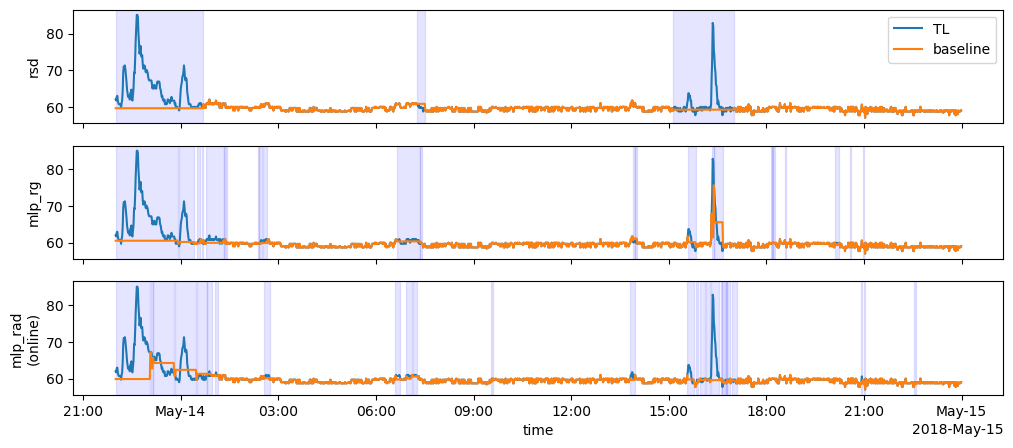

In [7]:
start = '2018-05-13T22'
end = '2018-05-14'
cml_plot = cmls.sel(time = slice(start, end)).isel(cml_id = 0, channel_id = 0)

# convert float to bool for plotting the shaded areas
cml_plot['wet_rsd'] = cml_plot.fillna(0).wet_rsd.astype(bool)
cml_plot['wet_mlp_rg'] = cml_plot.fillna(0).wet_mlp_rg.astype(bool)
cml_plot['wet_mlp_rad_online'] = cml_plot.fillna(0).wet_mlp_rad_online.astype(bool)

fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
cml_plot.tl.plot.line(x='time', ax=axs[0], label = 'TL');
cml_plot.tl.plot.line(x='time', ax=axs[1], label = 'TL');
cml_plot.tl.plot.line(x='time', ax=axs[2], label = 'TL');

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[0].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)

# shaded mlp_rg
cml_plot['wet_mlp_rg'][0] = 0 
cml_plot['wet_mlp_rg'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp_rg, -1) & ~cml_plot.wet_mlp_rg
wet_end = np.roll(cml_plot.wet_mlp_rg, 1) & ~cml_plot.wet_mlp_rg
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[1].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)

# shaded mlp rg online
cml_plot['wet_mlp_rad_online'][0] = 0 
cml_plot['wet_mlp_rad_online'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp_rad_online, -1) & ~cml_plot.wet_mlp_rad_online
wet_end = np.roll(cml_plot.wet_mlp_rad_online, 1) & ~cml_plot.wet_mlp_rad_online
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[2].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)



cml_plot.baseline_rsd.plot.line(x='time', ax=axs[0], label ='baseline');
cml_plot.baseline_mlp_rg.plot.line(x='time', ax=axs[1], label ='baseline');
cml_plot.baseline_mlp_rad_online.plot.line(x='time', ax=axs[2], label ='baseline');

axs[0].set_title('');
axs[0].set_xlabel('')
axs[1].set_title('');
axs[1].set_xlabel('')
axs[2].set_title('');

axs[0].set_ylabel('rsd')
axs[1].set_ylabel('mlp_rg')
axs[2].set_ylabel('mlp_rad\n(online)')

axs[0].legend(loc = 'upper right')

### Plot TL and baseline for another CML

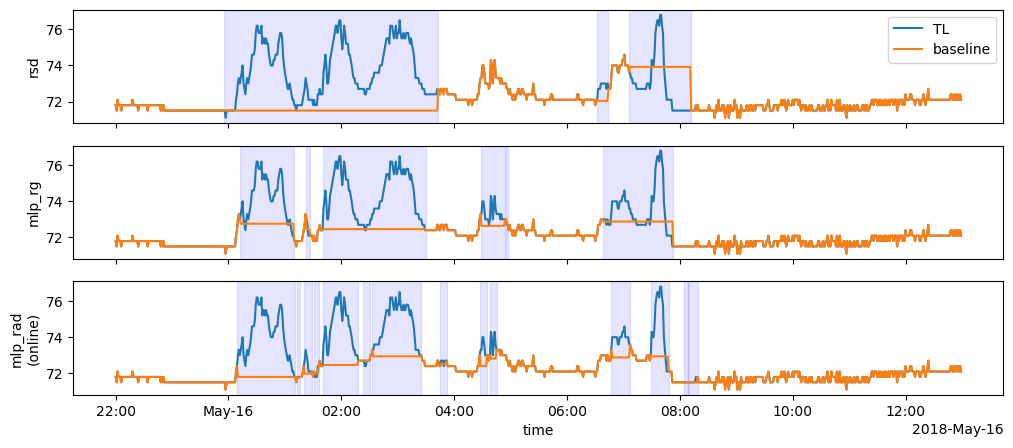

In [8]:
start = '2018-05-15T22'
end = '2018-05-16T12'
cml_plot = cmls.sel(time = slice(start, end)).isel(cml_id = 2, channel_id = 0)

# convert float to bool for plotting the shaded areas
cml_plot['wet_rsd'] = cml_plot.fillna(0).wet_rsd.astype(bool)
cml_plot['wet_mlp_rg'] = cml_plot.fillna(0).wet_mlp_rg.astype(bool)
cml_plot['wet_mlp_rad_online'] = cml_plot.fillna(0).wet_mlp_rad_online.astype(bool)

fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
cml_plot.tl.plot.line(x='time', ax=axs[0], label = 'TL');
cml_plot.tl.plot.line(x='time', ax=axs[1], label = 'TL');
cml_plot.tl.plot.line(x='time', ax=axs[2], label = 'TL');

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[0].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)

# shaded mlp_rg
cml_plot['wet_mlp_rg'][0] = 0 
cml_plot['wet_mlp_rg'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp_rg, -1) & ~cml_plot.wet_mlp_rg
wet_end = np.roll(cml_plot.wet_mlp_rg, 1) & ~cml_plot.wet_mlp_rg
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[1].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)

# shaded mlp rg online
cml_plot['wet_mlp_rad_online'][0] = 0 
cml_plot['wet_mlp_rad_online'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp_rad_online, -1) & ~cml_plot.wet_mlp_rad_online
wet_end = np.roll(cml_plot.wet_mlp_rad_online, 1) & ~cml_plot.wet_mlp_rad_online
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[2].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)



cml_plot.baseline_rsd.plot.line(x='time', ax=axs[0], label ='baseline');
cml_plot.baseline_mlp_rg.plot.line(x='time', ax=axs[1], label ='baseline');
cml_plot.baseline_mlp_rad_online.plot.line(x='time', ax=axs[2], label ='baseline');

axs[0].set_title('');
axs[0].set_xlabel('')
axs[1].set_title('');
axs[1].set_xlabel('')
axs[2].set_title('');

axs[0].set_ylabel('rsd')
axs[1].set_ylabel('mlp_rg')
axs[2].set_ylabel('mlp_rad\n(online)')

axs[0].legend(loc = 'upper right')